# Optimization of Transductive Conformal Predictors using Naive Bayes Classifier via Incremental and Decremental Learning

This notebook documents our experiments about implementation of standard and optimized TCPs using MultinomialNB or GaussianNB.

We first implement the Naive Bayes Classifiers for discrete and continuous variables, namely **MultinomialNB** and **GaussianNB**. Next, we define the **Nonconformity Measure Score (NMS)** and standard and optimized versions for **Transductive Conformal Predictor (TCP)** using the two classifiers. Finally, we compare their training time and average prediction time.

The code in this notebook refers to some ideas from the paper **Exact Optimization of Conformal Predictors via Incremental and Decremental Learning**, and use the utility class **eli.py** directly. You can find the paper, code and utility class in the link: https://github.com/gchers/exact-cp-optimization

# Settings

## Multiprocessing Settings

In [108]:
# Disable multithreading in numpy for fair measurements.
# Needs to be run before importing numpy.
import os
import ctypes
def disable_np_multithreading():
    """A multithreading-disabling routine for numpy, taken
    from https://github.com/numpy/numpy/issues/11826.
    """
    try:
        import mkl
        mkl.set_num_threads(1)
        return 0
    except:
        pass

    for name in [ "libmkl_rt.so", "libmkl_rt.dylib", "mkl_Rt.dll"]:
        try:
            mkl_rt = ctypes.CDLL(name)
            mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(1)))
            return 0
        except:
            pass

    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
disable_np_multithreading()

0

## Install Libraries

In [109]:
pip install sh

In [110]:
pip install arrow

In [111]:
pip install setproctitle

In [112]:
pip install flatten-dict

In [113]:
pip install parameterized

##  Import Libraries

In [114]:
# Import class Eli from the separate utility class file 'eli.py'.
from eli import Eli
import copy
import math
import time
import random
import unittest
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pylab as plt
from scipy.special import softmax
from sklearn import preprocessing
import matplotlib.ticker as ticker
from sklearn.datasets import load_iris
from parameterized import parameterized
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Plots Settings

In [115]:
DPI = 300
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
plt.style.use(['seaborn-v0_8-white', 'seaborn-v0_8-talk'])

# Definitions


## Functions


### compute_pvalues

In [116]:
# Define a function to compute p-values for x and all candidate class labels given
# a nonconformity measure ncm.
def compute_pvalues(x, labels, ncm):
    pvalues_x = []
    for y in labels:
        score_x, scores = ncm.compute_scores(x, y)
        scores = np.array(scores)
        pvalue = (1 + sum(scores >= score_x)) / (1 + len(scores))
        pvalues_x.append(pvalue)

    return pvalues_x

### cp_predict

In [117]:
# Define a function to return p-values and running time for x and all candidate
# class labels given a nonconformity measure ncm.
def cp_predict(Xtrain, Ytrain, Xtest, labels, ncm, return_time=False, timeout=None):

    # Record training time.
    start = time.perf_counter()
    ncm.train(Xtrain, Ytrain)
    train_time = time.perf_counter() - start

    # Record p-values and cumulative prediction time for each x in Xtest.
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False
    pvalues = []
    for x in Xtest:
        pvalues_x = compute_pvalues(x, labels, ncm)
        pvalues.append(pvalues_x)

        # Store prediction time.
        t = time.perf_counter() - start
        prediction_times.append(t)

        # Check if reached timeout.
        if timeout and t > timeout:
            reached_timeout = True
            break

    if return_time:
        return np.array(pvalues), {"training_time": train_time,
                                   "prediction_time": prediction_times,
                                   "reached_timeout": reached_timeout,
                                   }
    else:
        return np.array(pvalues)

### evaluate_ncm

In [118]:
# Define a function to evaluate running time for ncm.
def evaluate_ncm(ncm, train_size, max_test_size, n_classes, n_dimensions, timeout, is_mnb = False):

    # Parses the ncm expression and produce the ncm class instance.
    ncm_class = eval(ncm)
    ncm = ncm_class()

    # Use random generation function 'make_classification' from sklearn
    X, Y = make_classification(n_samples = train_size+max_test_size,
                               n_features = n_dimensions,
                               n_classes = n_classes)
    # Binarize X (set feature values to 0 or 1) according to the threshold 0.0.
    if is_mnb:
      X = Binarizer().fit_transform(X).astype(int)

    # Split the dataset into training and test sets, and all the objects in the
    # test set are going to do prediction.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=max_test_size)
    _, times = cp_predict(Xtrain, Ytrain, Xtest, np.unique(Y), ncm, return_time=True, timeout=timeout)

    # Return the times
    return times

## Classes


### NCM

In [119]:
# Define a class for nonconformity measures.
class NCM:

  def name(self):
    return self.__class__.__name__

  # By default, this simply stores the training data as an element of the NCM object.
  def train(self, X, Y):
      self.X = np.array(X)
      self.Y = np.array(Y)

  # Should return the nonconformity scorer for the training data (X, Y), which is a
  # function (x, y) -> score
  def train_ncm(self, X, Y):
      def example_scorer(x, y):
          raise NotImplemented

      return example_scorer

  # Returns a tuple: (score_x, scores) where score_x is the score for (x, y) and
  # scores are the nonconformity scores for the training examples.
  def compute_scores(self, x, y, only_score_x = False):
    ncm = self.train_ncm(self.X, self.Y)
    score_x = ncm(x, y)

    # If `only_score_x = True`, this method returns only the score for (x, y).
    if only_score_x:
        return score_x

    scores = []

    for i in range(len(self.X)):

        # Score the i-th example, removing it from the training data set and appending (x, y) instead.
        idx = np.array(list(range(len(self.X))))
        ncm = self.train_ncm(np.row_stack((self.X[idx!=i,:], x)),np.append(self.Y[idx!=i], y))
        scores.append(ncm(self.X[i,:], self.Y[i]))

    return score_x, scores

### MultinomialNB

In [120]:
# Define a class to implement Naive Bayes Classifier for discrete variables.
class MultinomialNB:

  def __init__(self):
    self.X = np.array
    self.Y = np.array
    self.instance_num = int
    self.feature_num = int
    self.class_num = int
    self.value_max = int
    self.class_count = np.array
    self.value_count = np.array

  # Define a function to fit the MultinomialNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_count'.
  def fit(self, X, Y):
    self.X = X
    self.Y = Y
    self.instance_num = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.class_num = np.unique(self.Y).shape[0]
    self.value_max = np.max(self.X)

    # Initialize the arrays 'self.class_count' and 'self.value_count'
    # and set the default value to be 0
    self.class_count = np.zeros(self.class_num)
    self.value_count = np.zeros((self.class_num, self.feature_num, self.value_max+1))

    # Fit the MultinomialNB on training data set and update the arrays
    # 'self.class_count' and 'self.value_count'.
    for x, y in zip(self.X, self.Y):
      self.class_count[y]+=1
      for f in np.arange(self.feature_num):
        self.value_count[y,f,x[f]]+=1

  # Define a function to calculate posterior probability for the data instance x.
  def predict_proba(self, x):
    probs_outcome = []

    for c in np.arange(self.class_num):

      # Calculate the prior class probability 'prior'.
      prior = self.class_count[c] / self.instance_num
      likelihood = 1

      for f in np.arange(self.feature_num):

        # Calculate the likelihood of each feature and multiply them together.
        likelihood *= self.value_count[c, f, x[f]]/self.class_count[c]

      # Calculate the final posterior probability for x.
      posterior = likelihood * prior
      probs_outcome.append(posterior)

    return probs_outcome

### TCP using MultinomialNB (TCPM)

In [121]:
# Define a class to implement Transductive Conformal Predictor using MultinomialNB.
class TCPM(NCM):
  def train_ncm(self, X, Y):
      mnb = MultinomialNB()
      mnb.fit(X, Y)

      def scorer(x, y):
        # Return the nonconformity score for a data instance x with class y.
        return -mnb.predict_proba(x)[y]

      # Return the scorer to score any test data instance.
      return scorer

### Optimized TCP using MultinomialNB (OTCPM)

In [122]:
# Define a class to implement Optimized Transductive Conformal Predictor using MultinomialNB.
# We overowrite the 'compute_scores' function using incremental and decremental learning.
class OTCPM(NCM):

  def __init__(self):
    self.X = np.array
    self.Y = np.array
    self.instance_num = int
    self.feature_num = int
    self.class_num = int
    self.value_max = int
    self.class_count = np.array
    self.value_count = np.array
    self.temporary_scores = np.array
    self.denominator_product = np.array

  # Define a function to fit the MultinomialNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_count'.
  def train(self, X, Y):
    self.X = X
    self.Y = Y
    self.instance_num = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.class_num = np.unique(self.Y).shape[0]
    self.value_max = np.max(self.X)

    # Initialize the arrays 'self.class_count' and 'self.value_count'
    # and set the default value to be 0
    self.class_count = np.zeros(self.class_num)
    self.denominator_product = np.zeros(self.class_num)
    self.value_count = np.zeros((self.class_num, self.feature_num, self.value_max+1))
    self.temporary_scores = np.zeros(self.instance_num)

    # Fit the MultinomialNB on training data set and update the arrays
    # 'self.class_count' and 'self.value_count'.
    for x, y in zip(self.X, self.Y):
      self.class_count[y]+=1
      for f in np.arange(self.feature_num):
        self.value_count[y,f,x[f]]+=1

    # Here we use a trick for speedup by multiplying all the denominators ahead, and
    # store in 'self.denominator_product'.
    for y in np.arange(self.class_num):
      self.denominator_product[y] = self.instance_num * ((self.class_count[y])**self.feature_num)

    # Precompute the score when unlearning a training instance, and store in
    # 'self.temporary_scores'.
    for i, (x, y) in enumerate(zip(self.X, self.Y)):
      prior = (self.class_count[y] - 1) / (self.instance_num -1)
      likelihood = 1
      for f in np.arange(self.feature_num):
            likelihood *= (self.value_count[y,f,x[f]]-1) / (self.class_count[y] - 1)

      posterior = likelihood * prior
      self.temporary_scores[i]=posterior

  def compute_scores(self, x, y, only_score_x=False):

    # Calculate the prior class count 'prior'.
    prior = self.class_count[y]
    likelihood = 1

    # Calculate the likelihood count of each feature and multiply them together.
    for f in np.arange(self.feature_num):
        likelihood *= self.value_count[y,f,x[f]]

    # Calculate the final posterior probability for x.
    posterior = likelihood * prior / self.denominator_product[y]

    score_x = -posterior

    # If `only_score_x = True`, this method returns only the score for (x, y).
    if only_score_x:
      return score_x

    # Add the test instance (x,y) to 'self.value_count'.
    for f in np.arange(self.feature_num):
      self.value_count[y,f,x[f]] += 1

    scores = []

    # Compute score for each instance in the training data set.
    for i, (x_out, y_out) in enumerate(zip(self.X, self.Y)):
      if y==y_out:
        prior = self.class_count[y_out]
        likelihood = 1
        for f in np.arange(self.feature_num):
          likelihood *= (self.value_count[y_out,f,x_out[f]]-1)
        posterior = likelihood * prior / self.denominator_product[y]
        scores.append(-posterior)
      else:
        scores.append(-self.temporary_scores[i]*(self.instance_num-1)/self.instance_num)

    # Remove the test instance (x,y) from 'self.value_count'.
    for f in np.arange(self.feature_num):
      self.value_count[y,f,x[f]] -= 1

    return score_x, scores

### GaussianNB


In [123]:
# Define a class to implement Naive Bayes Classifier for continuous variables.
class GaussianNB:

  def __init__(self):
    self.X = np.array
    self.Y = np.array
    self.instance_num = int
    self.feature_num = int
    self.class_num = int
    self.class_count = np.array
    self.value_sum = np.array

  # Define a function to fit the GaussianNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_sum'.
  def fit(self, X, Y):
    self.X = X
    self.Y = Y
    self.instance_num = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.class_num = np.unique(self.Y).shape[0]

    # Initialize the arrays 'self.class_count' and 'self.value_sum'
    # and set the default value to be 0
    self.class_count = np.zeros(self.class_num)
    # The thrid dimension of 'self.value_sum' store the 'sum of value' and 'sum of squares of value',
    # '0' for 'sum of value' and '1' for 'sum of squares of value'.
    self.value_sum = np.zeros((self.class_num, self.feature_num, 2))

    # Fit the GaussianNB on training data set and update the arrays
    # 'self.class_count' and 'self.value_sum'.
    for x, y in zip(self.X, self.Y):
      self.class_count[y]+=1
      for f in np.arange(self.feature_num):
        self.value_sum[y,f,0]+=x[f]
        self.value_sum[y,f,1]+=x[f]**2

  # Define a function to calculates posterior probability for a data object x.
  def predict_proba(self, x):
    probs_outcome = []

    for c in np.arange(self.class_num):

      # Calculate the prior class probability 'prior'.
      prior = self.class_count[c] / self.instance_num
      likelihood = 1

      # Calculate the likelihood of each feature and multiply them together.
      for f in np.arange(self.feature_num):
        mean = self.value_sum[c,f,0] / self.class_count[c]
        var = self.value_sum[c,f,1] / self.class_count[c] - mean**2
        likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x[f] - mean)**2 / (2*var))

      # Calculate the final posterior probability for x.
      posterior = likelihood * prior
      probs_outcome.append(posterior)

    return probs_outcome

### TCP using GaussianNB (TCPG)

In [124]:
# Define a class to implement Transductive Conformal Predictor using GaussianlNB.
class TCPG(NCM):

    def train_ncm(self, X, Y):
        gnb = GaussianNB()
        gnb.fit(X, Y)

        def scorer(x, y):
          # Return the nonconformity score for a data object x with label y.
          return -gnb.predict_proba(x)[y]

        # Return the scorer to score any test data object.
        return scorer

### Optimized TCP using GaussianNB (OTCPG)

In [125]:
# Define a class to implement Optimized Transductive Conformal Predictor using MultinomialNB.
# But we overowrite the 'compute_scores' function using incremental and decremental learning.
class OTCPG(NCM):

  def __init__(self):
    self.X = np.array
    self.Y = np.array
    self.instance_num = int
    self.feature_num = int
    self.class_num = int
    self.class_count = np.array
    self.value_sum= np.array
    self.temporary_scores = np.array

  # Define a function to fit the GaussianNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_sum'.
  def train(self, X, Y):
    self.X = X
    self.Y = Y
    self.instance_num = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.class_num = np.unique(self.Y).shape[0]

    # Initialize the arrays 'self.class_count' and 'self.value_sum'
    # and set the default value to be 0
    self.class_count = np.zeros(self.class_num)
    # The thrid dimension of 'self.value_sum' store the 'sum of value' and 'sum of squares of value',
    # '0' for 'sum of value' and '1' for 'sum of squares of value'.
    self.value_sum = np.zeros((self.class_num, self.feature_num, 2))
    self.temporary_scores = np.zeros(self.instance_num)

    # Fit the GaussianNB on training data set and update the arrays
    # 'self.class_count' and 'self.value_sum'.
    for x, y in zip(self.X, self.Y):
      self.class_count[y]+=1
      for f in np.arange(self.feature_num):
        self.value_sum[y,f,0]+=x[f]
        self.value_sum[y,f,1]+=x[f]**2

    # Precompute the score when unlearning a training instance, and store in
    # 'self.temporary_scores'.
    for i, (x, y) in enumerate(zip(self.X, self.Y)):
      prior = (self.class_count[y] - 1) / (self.instance_num -1)
      likelihood = 1

      for f in np.arange(self.feature_num):
        mean = (self.value_sum[y,f,0] - x[f]) / (self.class_count[y] - 1)
        var = (self.value_sum[y,f,1] - x[f]**2)/(self.class_count[y] - 1) - mean**2
        likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x[f] - mean)**2 / (2*var))

      posterior = likelihood * prior
      self.temporary_scores[i]=posterior

  def compute_scores(self, x, y, only_score_x=False):

    # Calculate the prior class probability 'prior'.
    prior = self.class_count[y] / self.instance_num
    likelihood = 1

    # Calculate the likelihood of each feature and multiply them together.
    for f in np.arange(self.feature_num):
      mean = self.value_sum[y,f,0] / self.class_count[y]
      var = self.value_sum[y,f,1] / self.class_count[y] - mean**2
      likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x[f] - mean)**2 / (2*var))

    # Calculate the final posterior probability for x.
    posterior = likelihood * prior

    score_x = -posterior

    # If `only_score_x = True`, this method returns only the prediction for (x, y).
    if only_score_x:
      return score_x

    # Add the test instance (x,y) to 'self.value_sum'.
    for f in np.arange(self.feature_num):
      self.value_sum[y,f,0] += x[f]
      self.value_sum[y,f,1] += x[f]**2

    scores = []

    for i, (x_out, y_out) in enumerate(zip(self.X, self.Y)):
      if y==y_out:
        prior = self.class_count[y_out]  / self.instance_num
        likelihood = 1

        for f in np.arange(self.feature_num):
          mean = (self.value_sum[y_out,f,0] - x_out[f]) / self.class_count[y_out]
          var = (self.value_sum[y_out,f,1] - x_out[f]**2)/self.class_count[y_out] - mean**2
          likelihood *= (1/np.sqrt(2*np.pi*var)) * np.exp(-(x_out[f] - mean)**2 / (2*var))

        posterior = likelihood * prior
        scores.append(-posterior)
      else:
        scores.append(-self.temporary_scores[i]*(self.instance_num-1)/self.instance_num)

    # Remove the test instance (x,y) from 'self.value_sum'.
    for f in np.arange(self.feature_num):
      self.value_sum[y,f,0] -= x[f]
      self.value_sum[y,f,1] -= x[f]**2

    return score_x, scores

# Correctness test

## MultinomialNB

In [126]:
# Define a class to test MultinomialNB on hand-calculated values.
# Mainly by comparing the output class prediction probabilities.
class MultinomialNB_Test(unittest.TestCase):

    def test_MultinomialNB(self):
      X = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [0, 1]])
      Y = np.array([0, 1, 1, 0, 1])
      x = [1, 1]

      """
      According to the training dataset above, we have 5 objects with 2 classes
      (2 objects for class "0" and 3 objects for class "1"), and 2 features.
      For each feature, we only have 2 types of feature values, both "0" and "1".
      We summarize the counts by classes, features and feature values in the table below.

      Class     Feature1_Value: "0"     Feature1_Value: "1"     Feature2_Value: "0"   Feature2_Value: "1"

      "0"       1                       1                       1                     1

      "1"       2                       1                       1                     2

      From this talbe, we can calculate the probability for the test object x.
      """

      # Probability for x to be 0
      prob_x_0 =  2/5 * 1/2 * 1/2
      # Probability for x to be 0
      prob_x_1 = 3/5 * 1/3 * 2/3

      expected_prob = list([prob_x_0, prob_x_1])

      # Use our custom function 'MultinomialNB' to output the probability.
      mnb = MultinomialNB()
      mnb.fit(X, Y)
      output = mnb.predict_proba(x)
      output = list(output)

      self.assertListEqual(output, expected_prob)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(MultinomialNB_Test)
_ = unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


## GaussianNB

In [127]:
# Define a class to test GaussianNB on hand-calculated values.
# Mainly by comparing the output class prediction probabilities.
class GaussianNB_Test(unittest.TestCase):

    def test_GaussianNB(self):
      X = np.array([[0.0, 0.1], [0.2, 0.3], [0.4, 0.5], [0.6, 0.7], [0.8, 0.9]])
      Y = np.array([0, 1, 1, 0, 1])
      x = [1.0, 1.0]

      # Get the class counts.
      count_c0 = np.sum(Y==0)
      count_c1 = np.sum(Y==1)

      # Get the mean and var by classes and features.
      mean_c0_f0 = np.mean(X[Y==0][:,0])
      mean_c0_f1 = np.mean(X[Y==0][:,1])
      mean_c1_f0 = np.mean(X[Y==1][:,0])
      mean_c1_f1 = np.mean(X[Y==1][:,1])
      var_c0_f0 = np.var(X[Y==0][:,0])
      var_c0_f1 = np.var(X[Y==0][:,1])
      var_c1_f0 = np.var(X[Y==1][:,0])
      var_c1_f1 = np.var(X[Y==1][:,1])

      # Probability for x to be 0
      prob_x_0 = count_c0 / 5 * (1/np.sqrt(2*np.pi*var_c0_f0)) * np.exp(-(x[0] - mean_c0_f0)**2 / (2*var_c0_f0)) \
                              * (1/np.sqrt(2*np.pi*var_c0_f1)) * np.exp(-(x[1] - mean_c0_f1)**2 / (2*var_c0_f1))

      # Probability for x to be 1
      prob_x_1 = count_c1 / 5 * (1/np.sqrt(2*np.pi*var_c1_f0)) * np.exp(-(x[0] - mean_c1_f0)**2 / (2*var_c1_f0)) \
                              * (1/np.sqrt(2*np.pi*var_c1_f1)) * np.exp(-(x[1] - mean_c1_f1)**2 / (2*var_c1_f1))

      expected_prob = [prob_x_0, prob_x_1]

      # Use our custom function 'MultinomialNB' to output the probability.
      gnb = GaussianNB()
      gnb.fit(X, Y)
      output = gnb.predict_proba(x)
      # Because the precision of the decimal point is different, we're just going to go to
      # 7 decimal places to see if it's equal.
      np.testing.assert_allclose(output, expected_prob, rtol=1e-7)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(GaussianNB_Test)
_ = unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


# Consistency test

## TCPM vs OTCPM


Testing: TCPM, OTCPM
p-value: 0.29 0.29


.
----------------------------------------------------------------------
Ran 1 test in 0.848s

OK


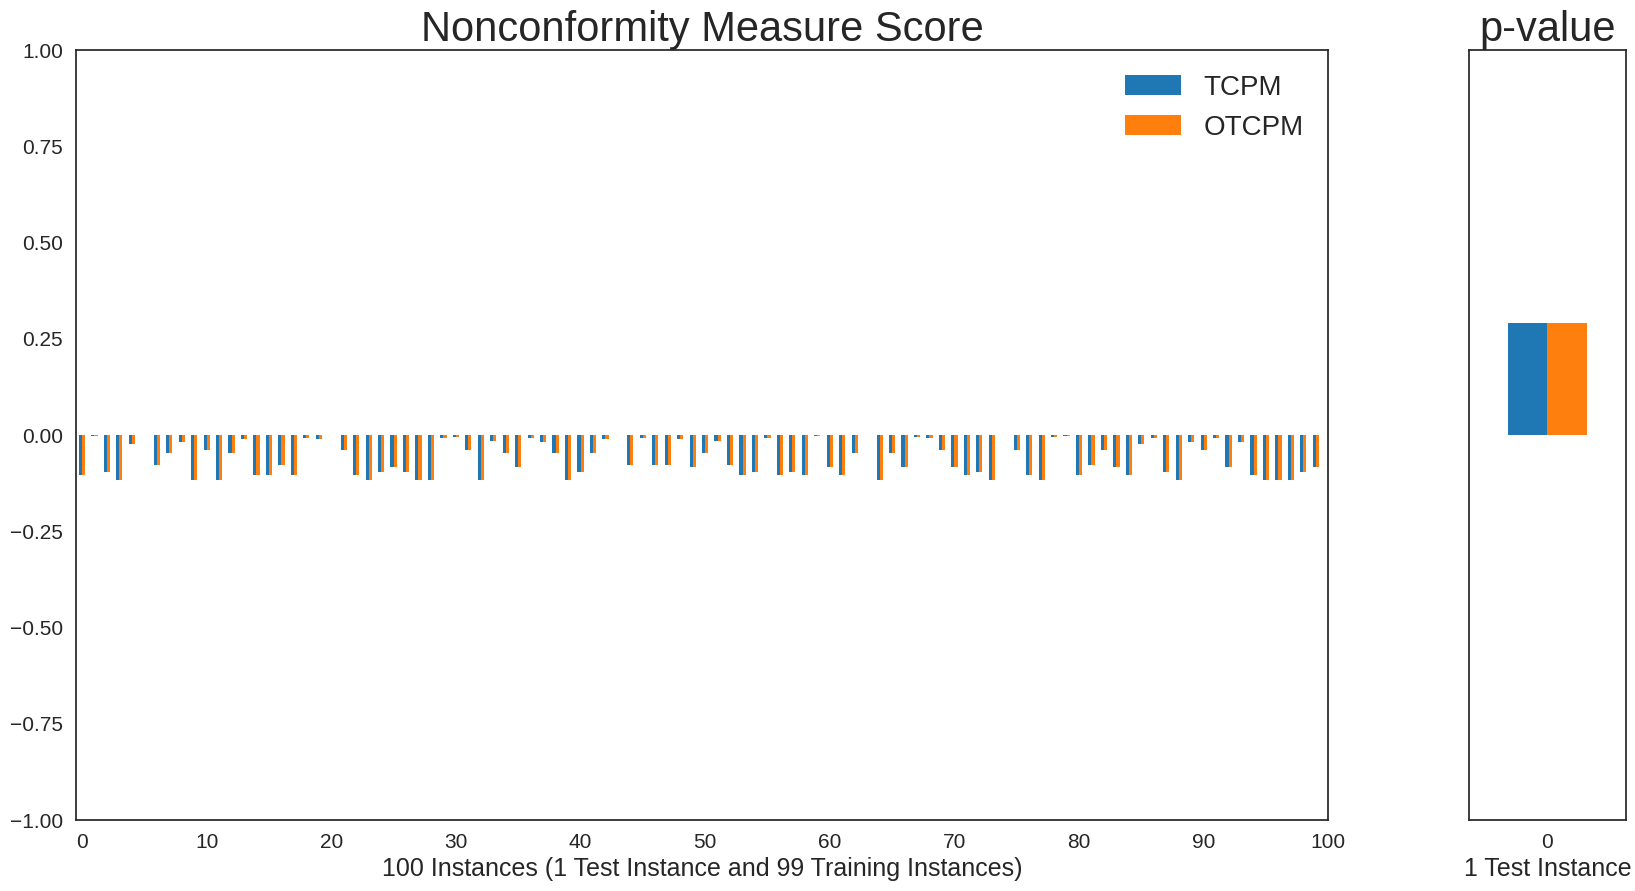

In [128]:
# Define a class to verify that TCPM is equivalent to OTCPM.
# Mainly by comparing nonconformity measure scores.
class TCPM_vs_OTCPM_Test(unittest.TestCase):

    def setUp(self):
        X, Y = load_iris(return_X_y=True)
        X = np.round(X).astype(int)
        # Only consider 2 classes (the first 100 instances, 50 for each class) for simplicity.
        X = X[0:100]
        Y = Y[0:100]

        np.random.seed(0)
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(X, Y, test_size=1, random_state=0)

    @parameterized.expand([
        [TCPM(), OTCPM()]])

    def test_equivalent(self, ncm_a, ncm_b, rtol=1e-07):
        print(f"Testing: {ncm_a.__class__.__name__}, {ncm_b.__class__.__name__}")
        ncm_a.train(self.Xtrain, self.Ytrain)
        ncm_b.train(self.Xtrain, self.Ytrain)

        for x, y in zip(self.Xtest, self.Ytest):
            score_x_a, scores_a = ncm_a.compute_scores(x, y)
            score_x_b, scores_b = ncm_b.compute_scores(x, y)
            pvalue_a = (1 + sum(score_x_a >= scores_a)) / (1 + len(scores_a))
            pvalue_b = (1 + sum(score_x_b >= scores_b)) / (1 + len(scores_b))
            np.testing.assert_allclose(score_x_a, score_x_b, rtol=rtol)
            np.testing.assert_allclose(scores_a, scores_b, rtol=rtol)
            np.testing.assert_allclose(pvalue_a, pvalue_b, rtol=rtol)

            print("p-value:", pvalue_a, pvalue_b)

            # Collect 100 nonconformity measure socres.
            scores_a = np.insert(scores_a, 0,score_x_a)
            scores_b = np.insert(scores_b, 0,score_x_b)

            score = pd.DataFrame(
                {'Index':np.arange(1,101),
                 'TCPM': scores_a,
                 'OTCPM': scores_b
                 })
            pvalue = pd.DataFrame(
                {'Index':np.arange(1,2),
                 'TCPM': pvalue_a,
                 'OTCPM': pvalue_b
                 })

            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10), gridspec_kw={'width_ratios': [8, 1]}, sharey = True)
            score.plot(x="Index", y=["TCPM", "OTCPM"], rot=0, kind="bar",ylim = (-1,1),xticks = np.arange(0,101,10),title = 'Nonconformity Measure Score',ax=axes[0])
            axes[0].title.set_size(30)
            axes[0].legend(fontsize=20)
            axes[0].set_xlabel('100 Instances (1 Test Instance and 99 Training Instances)', fontsize=18)
            axes[0].tick_params(axis='both', labelsize=15)
            pvalue.plot(x="Index", y=["TCPM", "OTCPM"], rot=0, kind="bar",ylim = (-1,1),xticks = np.arange(0,1,1),title = 'p-value', ax=axes[1], legend=False)
            axes[1].title.set_size(30)
            axes[1].set_xlabel('1 Test Instance', fontsize=18)
            axes[1].tick_params(axis='both', labelsize=15)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(TCPM_vs_OTCPM_Test)
_ = unittest.TextTestRunner().run(suite)

## TCPG vs OTCPG

Testing: TCPG, OTCPG
p-value: 0.27 0.27


.
----------------------------------------------------------------------
Ran 1 test in 0.525s

OK


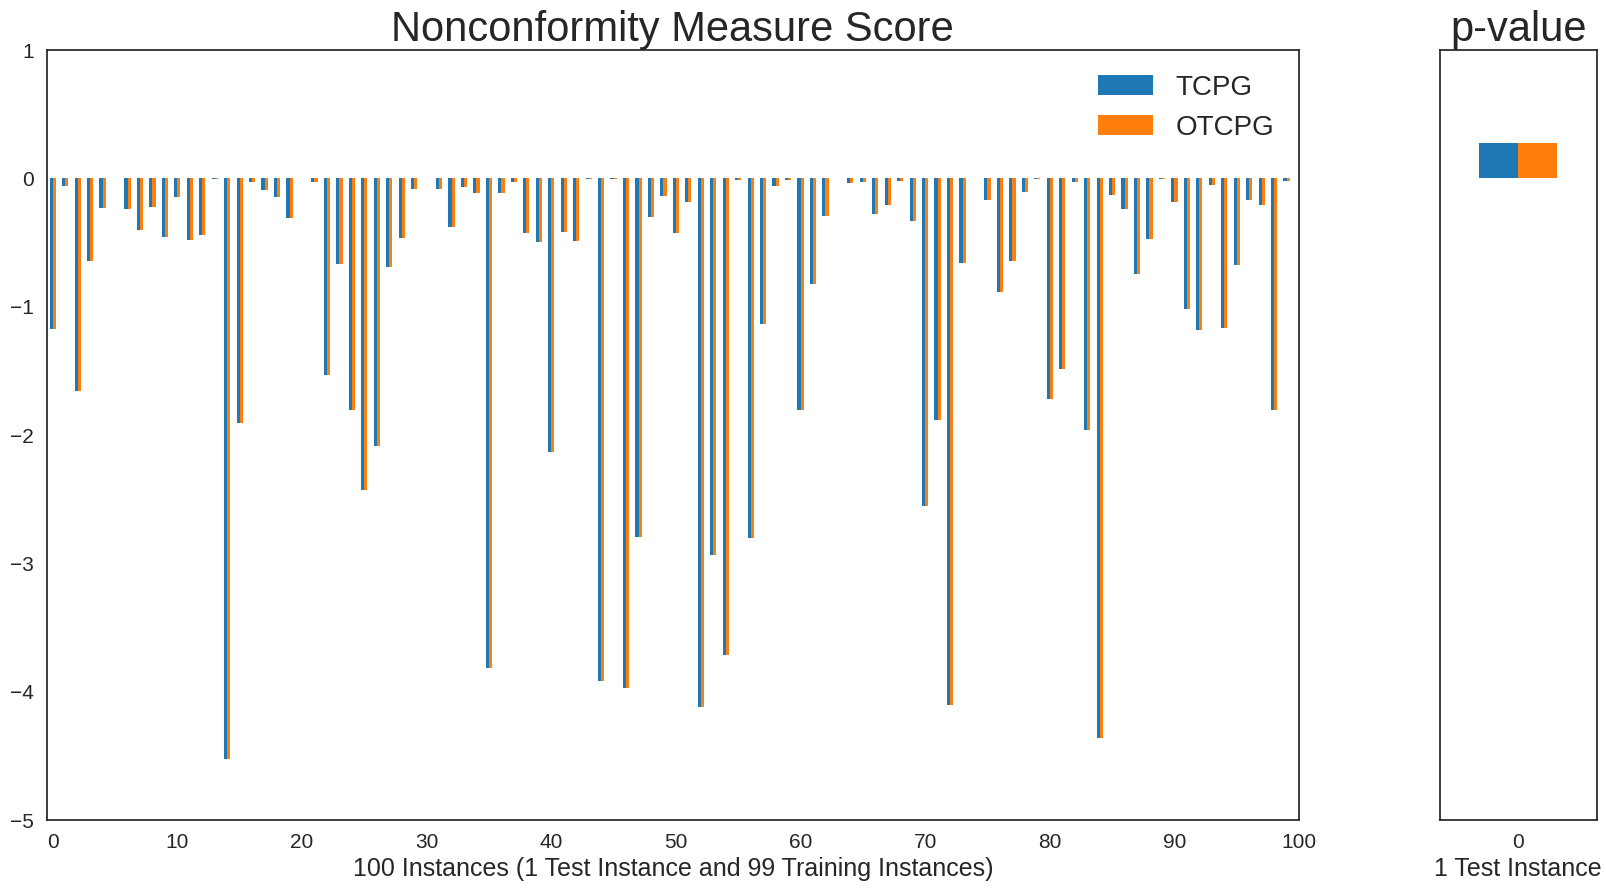

In [129]:
# Define a class to verify that TCPG is equivalent to OTCPG.
# Mainly by comparing nonconformity measure scores.
class TCPG_vs_OTCPG_Test(unittest.TestCase):

    def setUp(self):
        X, Y = load_iris(return_X_y=True)
        # Only consider 2 classes (the first 100 instances, 50 for each class) for simplicity.
        X = X[0:100]
        Y = Y[0:100]

        np.random.seed(0)
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(X, Y, test_size=1,random_state=0)

    @parameterized.expand([
        [TCPG(), OTCPG()]])

    def test_equivalent(self, ncm_a, ncm_b, rtol=1e-07):
        print(f"Testing: {ncm_a.__class__.__name__}, {ncm_b.__class__.__name__}")
        ncm_a.train(self.Xtrain, self.Ytrain)
        ncm_b.train(self.Xtrain, self.Ytrain)

        for x, y in zip(self.Xtest, self.Ytest):
            score_x_a, scores_a = ncm_a.compute_scores(x, y)
            score_x_b, scores_b = ncm_b.compute_scores(x, y)
            pvalue_a = (1 + sum(score_x_a >= scores_a)) / (1 + len(scores_a))
            pvalue_b = (1 + sum(score_x_b >= scores_b)) / (1 + len(scores_b))
            np.testing.assert_allclose(score_x_a, score_x_b, rtol=rtol)
            np.testing.assert_allclose(scores_a, scores_b, rtol=rtol)
            np.testing.assert_allclose(pvalue_a, pvalue_b, rtol=rtol)

            print("p-value:", pvalue_a, pvalue_b)

            # Collect 100 nonconformity measure socres.
            scores_a = np.insert(scores_a, 0,score_x_a)
            scores_b = np.insert(scores_b, 0,score_x_b)

            score = pd.DataFrame(
                {'Index':np.arange(1,101),
                 'TCPG': scores_a,
                 'OTCPG': scores_b
                 })
            pvalue = pd.DataFrame(
                {'Index':np.arange(1,2),
                 'TCPG': pvalue_a,
                 'OTCPG': pvalue_b
                 })

            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10), gridspec_kw={'width_ratios': [8, 1]}, sharey = True)
            score.plot(x="Index", y=["TCPG", "OTCPG"], rot=0, kind="bar",ylim = (-5,1),xticks = np.arange(0,101,10),title = 'Nonconformity Measure Score', ax=axes[0])
            axes[0].title.set_size(30)
            axes[0].legend(fontsize=20)
            axes[0].set_xlabel('100 Instances (1 Test Instance and 99 Training Instances)', fontsize=18)
            axes[0].tick_params(axis='both', labelsize=15)
            pvalue.plot(x="Index", y=["TCPG", "OTCPG"], rot=0, kind="bar",ylim = (-5,1),xticks = np.arange(0,1), title = 'p-value', ax=axes[1], legend=False)
            axes[1].title.set_size(30)
            axes[1].set_xlabel('1 Test Instance', fontsize=18)
            axes[1].tick_params(axis='both', labelsize=15)
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TCPG_vs_OTCPG_Test)
_ = unittest.TextTestRunner().run(suite)

# Computational performance comparison


## Experiment

### Set Up Parameters

In [130]:
EXPERIMENT_NAME = "training-size-comparison"
RESULTS_DIR = "results/"
REPETITIONS = 2
TRAIN_SIZE = np.logspace(1, 3, 10, dtype='int').tolist()
MAX_TEST_SIZE = 10
N_CLASSES = 2
N_DIMENSIONS = 30
TIMEOUT = 60*60*10

### Comparison between TCPM and OTCPM

In [93]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm=["TCPM","OTCPM"],
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   is_mnb = True
                  )

Running: results/training-size-comparison/ncm=TCPM-train_size=10-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=129-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=77-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=129-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/0.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=215-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=16-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/1.jsonRunning: results/training-size-comparison/ncm=OTCPM-train_size=359-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=True/0.

### Comparison between TCPG and OTCPG

In [94]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm=["TCPG","OTCPG"],
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   is_mnb = False
                  )

Running: results/training-size-comparison/ncm=TCPG-train_size=27-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=False/0.jsonRunning: results/training-size-comparison/ncm=TCPG-train_size=16-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=False/0.jsonRunning: results/training-size-comparison/ncm=TCPG-train_size=215-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=False/0.json

Running: results/training-size-comparison/ncm=TCPG-train_size=599-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=False/0.json
Running: results/training-size-comparison/ncm=TCPG-train_size=10-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=False/1.json
Running: results/training-size-comparison/ncm=OTCPG-train_size=599-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=False/0.jsonRunning: results/training-size-comparison/ncm=OTCPG-train_size=359-max_test_size=10-n_classes=2-n_dimensions=30-timeout=36000-is_mnb=F

## Results

In [131]:
# Load result data
eli = Eli(RESULTS_DIR)
results = eli.fetch_results("training-size-comparison")

# Define a function to return the average prediction time for each
# observation and store it in 'avg_time'.
avgerage_time = lambda vec: np.concatenate(([vec[0]], pd.Series(vec).diff()[1:])).mean()
results["avg_time"] = results.prediction_time.apply(avgerage_time)

print(f"{len(results)} observations")
results.head()

80 observations


,name,training_time,prediction_time,reached_timeout,ncm,train_size,max_test_size,n_classes,n_dimensions,timeout,is_mnb,repetition,git-commit,started,finished,avg_time
0,ncm=TCPG-train_size=129-max_test_size=10-n_cla...,0.000209,"[51.947599175000505, 88.11589626800014, 120.27...",False,TCPG,129,10,2,30,36000,False,1,no-git-repo,2023-07-02T15:10:00.194799+00:00,2023-07-02T15:14:34.657741+00:00,27.421739
1,ncm=TCPG-train_size=129-max_test_size=10-n_cla...,0.000148,"[52.27396616700025, 88.81309349300136, 121.030...",False,TCPG,129,10,2,30,36000,False,0,no-git-repo,2023-07-02T15:10:00.205435+00:00,2023-07-02T15:14:36.871164+00:00,27.644771
2,ncm=TCPM-train_size=129-max_test_size=10-n_cla...,0.000064,"[20.66888599000049, 36.77577133700015, 51.0660...",False,TCPM,129,10,2,30,36000,True,1,no-git-repo,2023-07-02T14:14:30.364372+00:00,2023-07-02T14:16:44.705471+00:00,13.407138
3,ncm=TCPM-train_size=129-max_test_size=10-n_cla...,0.000077,"[20.89399209000021, 36.77895815200009, 51.2074...",False,TCPM,129,10,2,30,36000,True,0,no-git-repo,2023-07-02T14:14:29.958569+00:00,2023-07-02T14:16:44.264840+00:00,13.382345
4,ncm=TCPG-train_size=359-max_test_size=10-n_cla...,0.000051,"[221.08426349399997, 355.63467623199904, 477.4...",False,TCPG,359,10,2,30,36000,False,1,no-git-repo,2023-07-02T15:10:00.255620+00:00,2023-07-02T15:29:15.971445+00:00,115.546239


In [132]:
MAX_TRAIN_SIZE = max(TRAIN_SIZE)
print("TCPM (train: {} test: {}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds \n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="TCPM") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="TCPM") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

print("OTCPM (train: {} test: {}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="OTCPM") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="OTCPM") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

print("TCPG (train: {} test: {}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="TCPG") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="TCPG") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

print("OTCPG (train: {} test: {}): \n\t Training Time: {} seconds \n\t Average Prediction Time: {} seconds".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="OTCPG") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="OTCPG") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

TCPM (train: 1000 test: 10): 
	 Training Time: 6.0167000356159406e-05 seconds 
	 Average Prediction Time: 206.11657529215 seconds 

OTCPM (train: 1000 test: 10): 
	 Training Time: 2.671623975500097 seconds 
	 Average Prediction Time: 0.9685100004500328 seconds

TCPG (train: 1000 test: 10): 
	 Training Time: 0.00012094049907318549 seconds 
	 Average Prediction Time: 369.80029570175003 seconds

OTCPG (train: 1000 test: 10): 
	 Training Time: 12.321689486499963 seconds 
	 Average Prediction Time: 5.242002800499904 seconds


## Plots



### Training Time

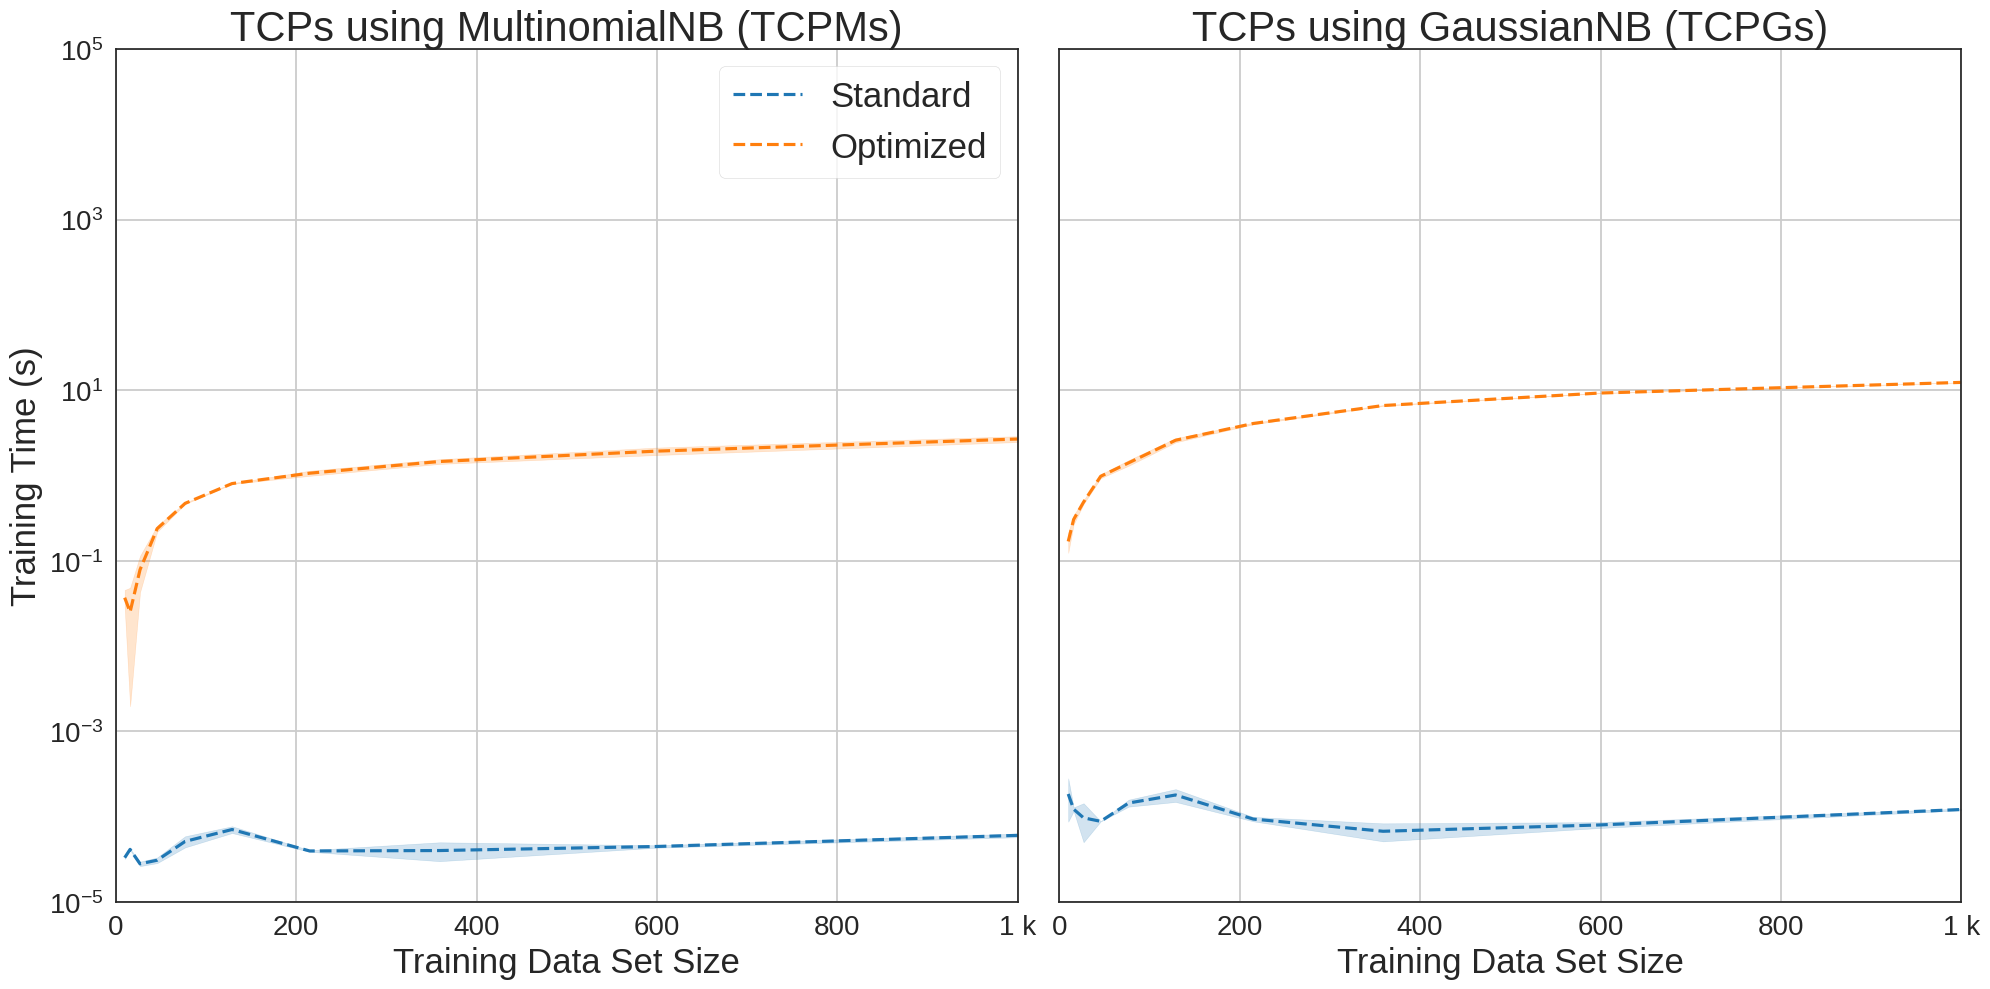

In [136]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 10))
colors = sns.color_palette()
NCMS = ["TCPM","TCPG"]

for i, (ax, ncm) in enumerate(zip(axes.flat, NCMS)):
    plot_data = results[((results.ncm == ncm) | (results.ncm == "O"+ncm))]

    sns.lineplot(x="train_size", y="training_time",
                 data=plot_data[plot_data.ncm==ncm],
                 ax=ax, legend=None, label="Standard",
                 color=colors[0])
    sns.lineplot(x="train_size", y="training_time",
                 data=plot_data[plot_data.ncm=="O"+ncm],
                 ax=ax, legend=None, label="Optimized",
                 color=colors[1])

    ax.lines[0].set_linestyle("--")
    ax.lines[1].set_linestyle("--")

    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.tick_params(axis='both',labelsize=20)
    ax.grid()
    ax.set_xlim([0, 10**3])
    ax.set_ylim([10**-5, 10**5])
    ax.set_title("TCPs using MultinomialNB (TCPMs)" if NCMS[i][3]=="M" else "TCPs using GaussianNB (TCPGs)", fontsize=30)
    ax.set_xlabel("Training Data Set Size", fontsize=25)
    ax.set_ylabel("Training Time (s)",fontsize=25)
    if i == 0:
        ax.legend(title="", loc="best", frameon=True, fontsize=25)
    else:
        ax.set_ylabel(None)
        plt.setp(ax.get_yticklabels(), visible=False)

plt.tight_layout()

### Averge Prediction Time

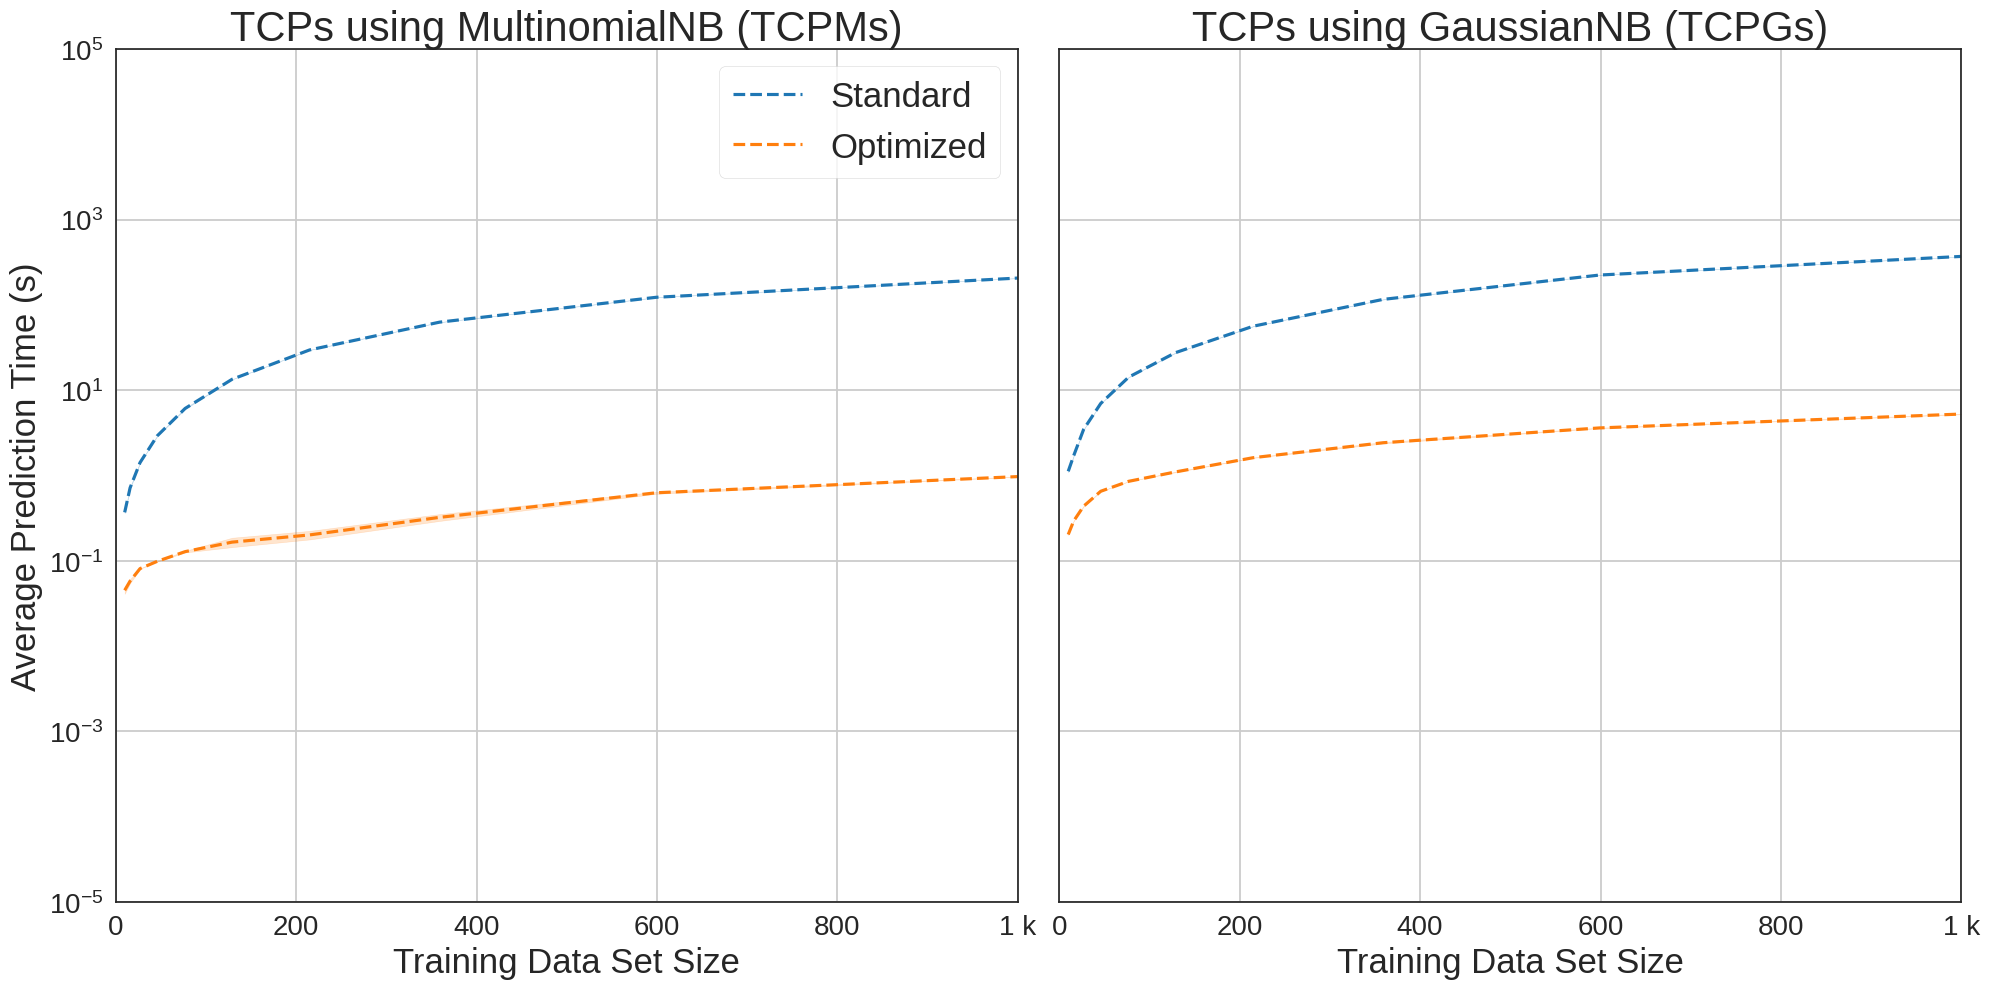

In [135]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 10))
colors = sns.color_palette()
NCMS = ["TCPM","TCPG"]

for i, (ax, ncm) in enumerate(zip(axes.flat, NCMS)):
    plot_data = results[((results.ncm == ncm) | (results.ncm == "O"+ncm))]

    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm== ncm],
                 ax=ax, legend=None, label="Standard",
                 color=colors[0])
    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm=="O"+ncm],
                 ax=ax, legend=None, label="Optimized",
                 color=colors[1])

    ax.lines[0].set_linestyle("--")
    ax.lines[1].set_linestyle("--")

    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.tick_params(axis='both',labelsize=20)
    ax.grid()
    ax.set_xlim([0, 10**3])
    ax.set_ylim([10**-5, 10**5])
    ax.set_title("TCPs using MultinomialNB (TCPMs)" if NCMS[i][3]=="M" else "TCPs using GaussianNB (TCPGs)", fontsize=30)
    ax.set_xlabel("Training Data Set Size", fontsize=25)
    ax.set_ylabel("Average Prediction Time (s)",fontsize=25)
    if i == 0:
        ax.legend(title="", loc="best", frameon=True, fontsize=25)
    else:
        ax.set_ylabel(None)
        plt.setp(ax.get_yticklabels(), visible=False)

plt.tight_layout()